In [12]:
import numpy as np
import os
from skimage import io
from skimage.transform import resize
from sklearn.feature_extraction import image
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, ConfusionMatrixDisplay
from scipy.fftpack import dct
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle

In [3]:
# Function to extract DCT features from an image
def extract_dct(img):
    img_dct = dct(img, type=2, norm="ortho", axis=0)
    img_dct = dct(img_dct, type=2, norm="ortho", axis=1)
    img_dct = np.abs(img_dct)
    img_dct += 1e-13
    img_dct = np.log(img_dct)
    img_dct -= np.mean(img_dct)
    img_dct /= np.std(img_dct)

    return img.flatten(), img_dct

# Function to load images from folder
def load_images_from_folder(folder_path, image_size=(128, 128)):
    images = []
    for filename in os.listdir(folder_path):
        img = io.imread(os.path.join(folder_path, filename), as_gray=True)
        img = resize(img, image_size)
        images.append(img)
    print(len(images))
    return images

# Function to display images and their DCT frequency spectra side by side
def display_images_with_dct(images, title="Image and DCT Spectrum"):
    plt.figure(figsize=(12, 6))
    for i, img in enumerate(images[:5]):  # Display first 5 images for simplicity
        # Original Image
        plt.subplot(2, 5, i + 1)
        plt.imshow(img)
        plt.title("Original Image")
        plt.axis('off')

        # DCT Spectrum
        _, dct_img = extract_dct(img)
        plt.subplot(2, 5, i + 6)
        im = plt.imshow(dct_img, cmap='coolwarm') 
        plt.imshow(dct_img, cmap='coolwarm')
        plt.title("DCT Spectrum")
        plt.axis('off')
        plt.colorbar(im, fraction=0.046, pad=0.04)

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

In [4]:
# Load real and fake images from the respective folders
real_train_images = load_images_from_folder('dataset/Kandinsky_Outdoor/train/real')
fake_train_images = load_images_from_folder('dataset/Kandinsky_Outdoor/train/gen')
real_val_images = load_images_from_folder('dataset/Kandinsky_Outdoor/val/real')
fake_val_images = load_images_from_folder('dataset/Kandinsky_Outdoor/val/gen')

25000
25000
5000
5000


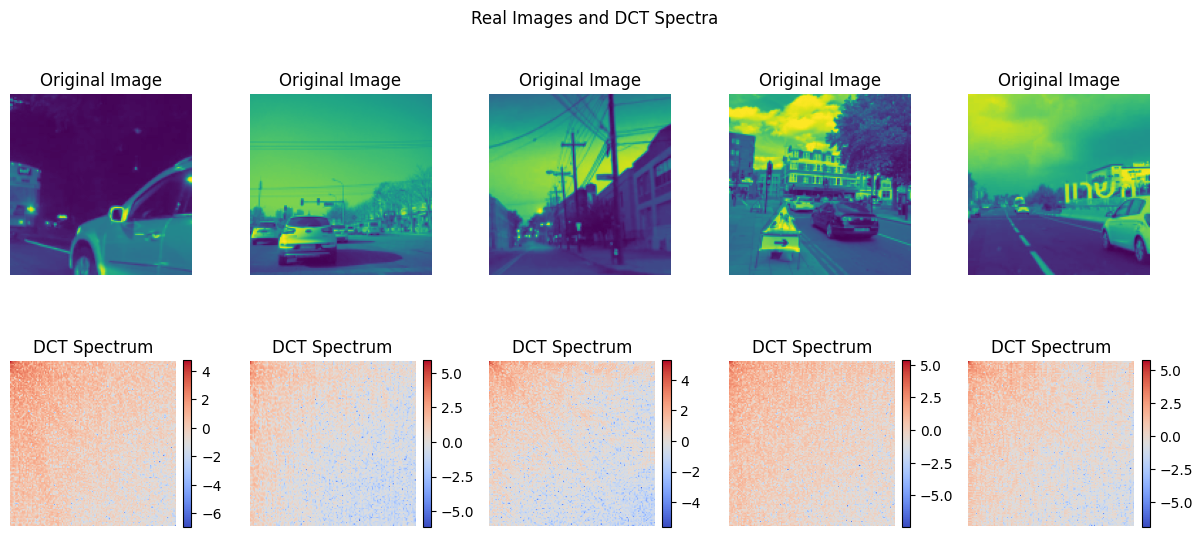

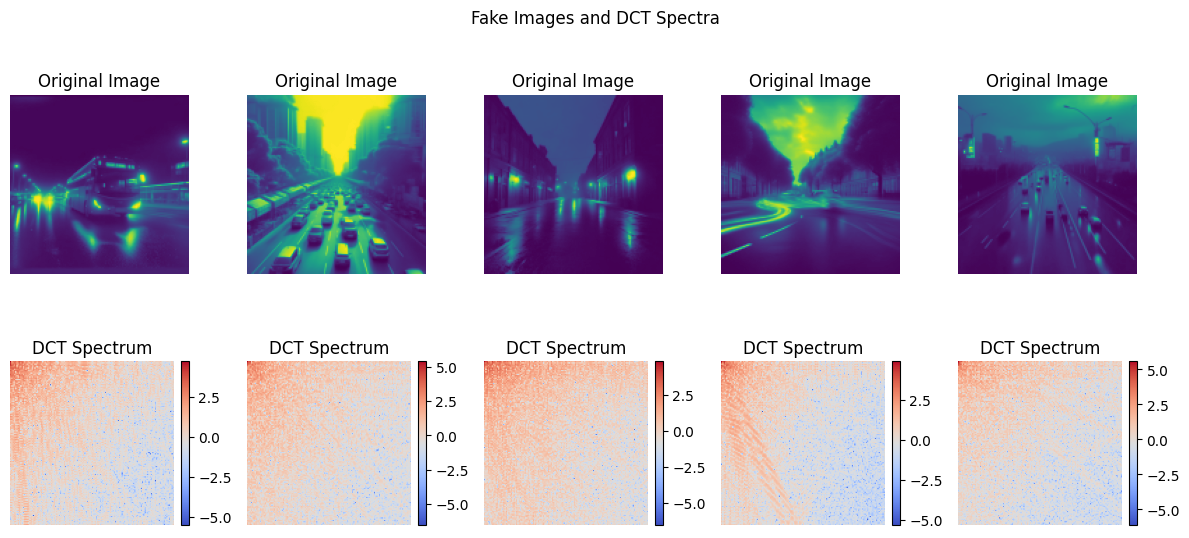

In [5]:
# Display real and fake images with their DCT spectra
display_images_with_dct(real_train_images, title="Real Images and DCT Spectra")
display_images_with_dct(fake_train_images, title="Fake Images and DCT Spectra")

In [5]:
# Extract DCT features from images
X_train_real = np.array([extract_dct(img)[0] for img in real_train_images])[:15000]
X_train_fake = np.array([extract_dct(img)[0] for img in fake_train_images])[:15000]
X_val_real = np.array([extract_dct(img)[0] for img in real_val_images])[:2000]
X_val_fake = np.array([extract_dct(img)[0] for img in fake_val_images])[:2000]


In [6]:
# Create labels for real and fake images
y_train_real = np.zeros(len(X_train_real))
y_train_fake = np.ones(len(X_train_fake))
y_val_real = np.zeros(len(X_val_real))
y_val_fake = np.ones(len(X_val_fake))

In [7]:
# Combine real and fake images for training and validation
X_train = np.vstack((X_train_real, X_train_fake))
y_train = np.hstack((y_train_real, y_train_fake))
X_val = np.vstack((X_val_real, X_val_fake))
y_val = np.hstack((y_val_real, y_val_fake))

In [9]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Train Ridge Regression classifier on the training set
ridge_clf = RidgeClassifier(alpha=1.0)
ridge_clf.fit(X_train, y_train)

RidgeClassifier()

In [9]:
# Predict on the validation set
y_pred = ridge_clf.predict(X_val)
y_prob = ridge_clf.decision_function(X_val)  # Confidence scores for ROC

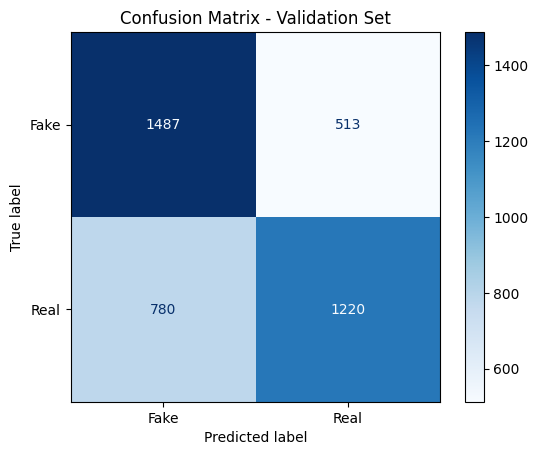

In [10]:
# Calculate accuracy on the validation set
accuracy = accuracy_score(y_val, y_pred)

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Real"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Validation Set")
plt.show()

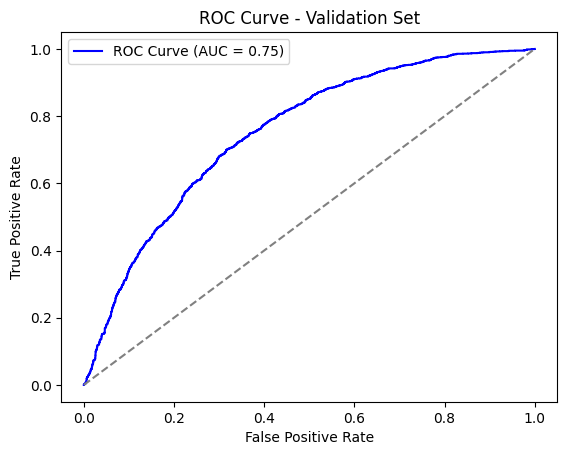

Validation Accuracy: 0.67675


In [11]:
# ROC Curve and AUC Score for validation set
fpr, tpr, _ = roc_curve(y_val, y_prob)
auc_score = roc_auc_score(y_val, y_prob)
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Validation Set")
plt.legend(loc="best")
plt.show()

print("Validation Accuracy:", accuracy)

In [13]:
# Save the trained model
with open('my_model_dct.pkl', 'wb') as f:
    pickle.dump(ridge_clf, f)